In [9]:
!pip install torchdiffeq torchsde torchdyn torchcfm

In [10]:
%load_ext autoreload
%autoreload 2
import os

import matplotlib.pyplot as plt
import torch
import torchdiffeq
import torchsde
from torchdyn.core import NeuralODE
from torchvision import datasets, transforms
from torchvision.transforms import ToPILImage
from torchvision.utils import make_grid
from tqdm import tqdm

from torchcfm.conditional_flow_matching import *
from torchcfm.models.unet import UNetModel

savedir = "models/cond_mnist"
os.makedirs(savedir, exist_ok=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
batch_size = 128
n_epochs = 1

trainset = datasets.MNIST(
    "../data",
    train=True,
    download=True,
    transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]),
)

train_loader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True, drop_last=True
)

In [12]:
#################################
#    Class Conditional CFM
#################################

sigma = 0.0
model = UNetModel(
    dim=(1, 28, 28), num_channels=32, num_res_blocks=1, num_classes=10, class_cond=True
).to(device)
optimizer = torch.optim.Adam(model.parameters())
FM = ConditionalFlowMatcher(sigma=sigma)
# Users can try target FM by changing the above line by
# FM = TargetConditionalFlowMatcher(sigma=sigma)
node = NeuralODE(model, solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4)

In [13]:
for epoch in range(n_epochs):
    for i, data in enumerate(train_loader):
        optimizer.zero_grad()
        x1 = data[0].to(device)
        y = data[1].to(device)
        x0 = torch.randn_like(x1)
        t, xt, ut = FM.sample_location_and_conditional_flow(x0, x1)
        vt = model(t, xt, y)
        loss = torch.mean((vt - ut) ** 2)
        loss.backward()
        optimizer.step()
        print(i,loss.item())
        print(f"epoch: {epoch}, steps: {i}, loss: {loss.item():.4}", end="\r")

0 1.9168106317520142
1 1.8644907474517822
2 1.7471390962600708
3 1.6471588611602783
4 1.5245366096496582
5 1.4134963750839233
6 1.3066269159317017
7 1.1861597299575806
8 1.0908639430999756
9 1.0137194395065308
10 0.9298128485679626
11 0.8740339875221252
12 0.7838432788848877
13 0.7041156888008118
14 0.659160852432251
15 0.6177113652229309
16 0.6026578545570374
17 0.5838691592216492
18 0.5326082706451416
19 0.5285093188285828
20 0.5048869848251343
21 0.47661036252975464
22 0.4624690115451813
23 0.47270309925079346
24 0.4563620090484619
25 0.446021169424057
26 0.4542141556739807
27 0.4152638912200928
28 0.4213491380214691
29 0.40771132707595825
30 0.3995243012905121
31 0.3931567072868347
32 0.4009908437728882
33 0.37997397780418396
34 0.3514512777328491
35 0.35871702432632446
36 0.360065758228302
37 0.34276407957077026
38 0.345615029335022
39 0.33910781145095825
40 0.34745872020721436
41 0.3443230092525482
42 0.3329883813858032
43 0.31147652864456177
44 0.3099454343318939
45 0.2997851669

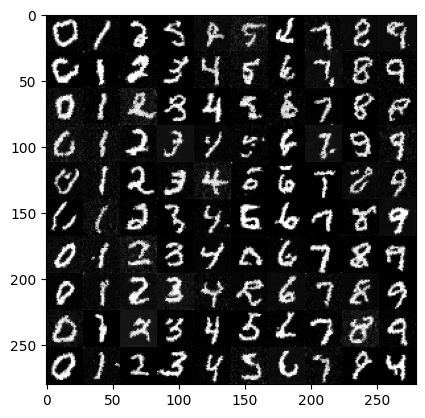

In [14]:
USE_TORCH_DIFFEQ = True
generated_class_list = torch.arange(10, device=device).repeat(10)
with torch.no_grad():
    if USE_TORCH_DIFFEQ:
        traj = torchdiffeq.odeint(
            lambda t, x: model.forward(t, x, generated_class_list),
            torch.randn(100, 1, 28, 28, device=device),
            torch.linspace(0, 1, 2, device=device),
            atol=1e-4,
            rtol=1e-4,
            method="dopri5",
        )
    else:
        traj = node.trajectory(
            torch.randn(100, 1, 28, 28, device=device),
            t_span=torch.linspace(0, 1, 2, device=device),
        )
grid = make_grid(
    traj[-1, :100].view([-1, 1, 28, 28]).clip(-1, 1), value_range=(-1, 1), padding=0, nrow=10
)
img = ToPILImage()(grid)
plt.imshow(img)
plt.show()